<div align="center"> 

---

# **Alcohol consumption pattern**

</div>

----

<div align="center"> 

![ModelDesign_IA2BC.png]()

</div>

---
# <u> **Description:**</u>

Alcohol consumption of the rats of the six batches over the four months of the protocol.

---

## **Workflow**

1. Downloading files from drive
2. Data preparation
3. Analyses
4. Exploratory data
5. Visualization

---

**Variables to consider:** 
  - Session
  - Sex  
  
**Metrics**
  - Consumption pattern
  - Alcohol deprivation effect (ADE)
  
**Analysis:**
  - Latent class analysis 

---

### **General settings options**

In [1]:
addTaskCallback(function(...) {set.seed(42);TRUE})
options(warn=-1) # to turn off warnings
#options(warn=0) # to turn on warnings
options(repr.plot.width=12, repr.plot.height=8) # to resize plots

1 
1

## **1. Downloading files from drive**

### **1.1 Load  R packages and dependencies.** 

  The following packages are needed for the to move on, firstly it is needed to download pacman library

 ---

In [2]:
# Make sure to install pacman before we begin
  if (!require("pacman")) {
  install.packages("pacman")
  }

# Load required packages  
  pacman::p_load(tidyverse,devtools,ggpubr,ggthemes,SmartEDA,lme4,performance,rstatix,data.table,timesaveR,
    hablar,cowplot,lcmm,plotrix,report,broom,easystats,emmeans,sjPlot,ggdist,gghalves,ggmap,readxl,drc,minpack.lm,
    lazyWeave)


Loading required package: pacman



In [3]:
## Settings color and theme

pal_group <- c("#757575","#C96505","#00A087","#09467C")
pal_sex <- c(alpha("#8E5A9C",1),alpha("#2879BC",1))
theme_settings <- theme(text = element_text(size=20,family = "Times New Roman"),axis.text.x = element_text(size=18),legend.title=element_blank())

In [4]:
setwd("/mnt/c/Users/jalil/phd/PhD/Psilantro/Sudmex_alcohol_stress/")

## **2. Data preparation**

Reading files and set it all up for Alcohol group

In [5]:
DBM_dataset <- read_csv("Data/DBM_dataset.csv") 

Rows: 351 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): RID, Session, Subject, Group, Batch, Sex, IN
dbl (1): Age

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
RID_group <- DBM_dataset %>% dplyr::select(RID,Group,Sex,Batch) %>% unique() 
RID_group <- RID_group %>% mutate(RID = case_when(map_dbl(str_split(RID_group$RID, pattern = "-"), 
        function(x) as.numeric(x[2])) < 10 ~ paste0("sub-00",map_dbl(str_split(RID_group$RID, pattern = "-"), function(x) as.numeric(x[2]))),
        map_dbl(str_split(RID_group$RID, pattern = "-"), 
        function(x) as.numeric(x[2])) < 100 ~ paste0("sub-0",map_dbl(str_split(RID_group$RID, pattern = "-"), function(x) as.numeric(x[2]))),
        map_dbl(str_split(RID_group$RID, pattern = "-"), 
        function(x) as.numeric(x[2])) >= 100 ~ paste0("sub-",map_dbl(str_split(RID_group$RID, pattern = "-"), function(x) as.numeric(x[2]))) ),
        .before = 1) %>% 
        mutate_if(is.character, as.factor)

In [7]:
RID_group %>% write_csv("Data/RID_group.csv")

In [8]:
# RID_group %>% filter(Group == "Alc+Str") %>% filter(Sex == "female")

In [9]:
suppressMessages(
dataset_alcohol <- list.files(path = paste0(getwd(),"/Data/Datasets"), full.names = T) %>% map(~ .x %>% read_csv()) %>% plyr::rbind.fill() %>% 
  convert(chr(Sex,Session,Phase), num(Age,Weight_kg,EtOH,H2O)) %>% 
  filter(Condition_day == "EtOH") %>%
  dplyr::select(RID,Sex,Session,Age,Weight_kg,Group,Condition,EtOH,H2O,Phase,Batch) %>%
  pivot_longer(cols=c(EtOH, H2O), values_to = "value", names_to = "Bottle") %>%
  pivot_wider(names_from = "Condition",values_from = "value") %>% 
  group_by(Bottle) 
    )

In [10]:
### Important issue: What point to set the NA threshold, that is, how much do the rats drank at 24 hrs ###

Alcohol_thresh <- dataset_alcohol %>% mutate(`24_hrs` = case_when(`24_hrs` >=60 ~ `24_hrs`))

General_intake <- Alcohol_thresh %>% 
      mutate(start_30mins = start - `30_mins`, 
            start_24_hrs = start - `24_hrs`,
            main_intake = (start_24_hrs * Weight_kg),
      basal_start = start - 27, 
      basal_30min = `30_mins` - 27,
      Basal_24hrs = `24_hrs` - 27,
      T_30min = basal_start - basal_30min,
      T_24hrs = basal_start - Basal_24hrs,
      Total_fluid_intake_24 = (T_24hrs * 100)/98.0608,
      Total_fluid_intake_30 = (T_30min * 100)/98.0608,
      Binge = (start_30mins* Weight_kg),
      Preferency = main_intake/Total_fluid_intake_24) %>%
      mutate(Sex = factor(Sex),
      Phase = factor(Phase)) %>% 
      mutate(RID = case_when(RID < 10 ~ paste0("sub-00",RID),
            RID < 100 ~ paste0("sub-0",RID),
            RID >= 100 ~ paste0("sub-",RID) ), .before = 1) %>% 
      filter(RID %in% RID_group$RID) %>% 
      mutate(Group = factor(Group, levels = c("Ctrl","Alc","Str","Alc+Str"))) 


Alcohol_intake <- General_intake %>%
      filter(Group == "Alc" | Group == "Alc+Str") %>%
      filter(Bottle == "EtOH") %>% 
      ungroup 

In [11]:
AI_extremes <- Alcohol_intake %>% group_by(Group,Session) %>% identify_outliers(main_intake) %>% filter(is.extreme == TRUE) 
AI_extremes_NA <- AI_extremes %>% mutate(main_intake = case_when(main_intake <=12 ~ main_intake )) %>% dplyr::select(-c(is.outlier,is.extreme))

Alcohol_intake <- Alcohol_intake %>% anti_join(AI_extremes) %>% bind_rows(AI_extremes_NA) 
AI_extremesB <- Alcohol_intake %>% group_by(Group,Session) %>% identify_outliers(Binge) %>% filter(is.extreme == TRUE) 
AI_extremesB_NA <- AI_extremesB %>% mutate(Binge = case_when(Binge <= 5 ~ Binge)) %>% 
                dplyr::select(-c(is.outlier,is.extreme))
Alcohol_intake <- Alcohol_intake %>% anti_join(AI_extremesB) %>% bind_rows(AI_extremesB_NA) 

Joining with `by = join_by(RID, Sex, Session, Age, Weight_kg, Group, Phase,
Batch, Bottle, start, `30_mins`, `24_hrs`, start_30mins, start_24_hrs,
main_intake, basal_start, basal_30min, Basal_24hrs, T_30min, T_24hrs,
Total_fluid_intake_24, Total_fluid_intake_30, Binge, Preferency)`
Joining with `by = join_by(RID, Sex, Session, Age, Weight_kg, Group, Phase,
Batch, Bottle, start, `30_mins`, `24_hrs`, start_30mins, start_24_hrs,
main_intake, basal_start, basal_30min, Basal_24hrs, T_30min, T_24hrs,
Total_fluid_intake_24, Total_fluid_intake_30, Binge, Preferency)`


## **3. Exploratory data**

In [12]:
ExpNumStat(Alcohol_intake,by="A",MesofShape=1,Outlier=TRUE,round=2)
# Low percentage of missing data and outliers

,Vname,Group,TN,nNeg,nZero,nPos,NegInf,PosInf,NA_Value,Per_of_Missing,⋯,min,max,mean,median,SD,CV,IQR,LB.25%,UB.75%,nOutliers
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,24_hrs,All,1908,0,0,1840,0,0,68,3.56,⋯,64.00,128.00,112.47,114.00,7.31,0.07,7.00,99.50,127.50,95
4,30_mins,All,1908,0,0,1863,0,0,45,2.36,⋯,96.00,130.00,118.69,119.00,3.58,0.03,2.00,115.00,123.00,134
1,Age,All,1908,0,0,1908,0,0,0,0.00,⋯,45.00,144.00,91.28,85.00,29.98,0.33,55.00,-18.50,201.50,0
11,Basal_24hrs,All,1908,0,0,1840,0,0,68,3.56,⋯,37.00,101.00,85.47,87.00,7.31,0.09,7.00,72.50,100.50,95
10,basal_30min,All,1908,0,0,1863,0,0,45,2.36,⋯,69.00,103.00,91.69,92.00,3.58,0.04,2.00,88.00,96.00,134
9,basal_start,All,1908,0,0,1862,0,0,46,2.41,⋯,70.00,102.00,92.80,93.00,3.23,0.03,2.00,89.00,97.00,99
16,Binge,All,1908,70,644,1130,0,0,64,3.35,⋯,-1.82,4.85,0.35,0.25,0.52,1.50,0.49,-0.74,1.23,115
8,main_intake,All,1908,1,55,1728,0,0,124,6.50,⋯,-0.24,12.82,2.17,1.64,1.93,0.89,2.26,-2.65,6.40,79
17,Preferency,All,1908,0,0,1740,0,0,168,8.81,⋯,0.07,0.57,0.30,0.27,0.10,0.33,0.14,0.01,0.58,0


## **4. Analysis**

1. Consumption pattern
2. Alcohol deprivation effect
3. Weight change

### 4.1 Consumption pattern

In [13]:
Model_AlcInt <- lmer(formula = main_intake ~ Group*Age*Sex+Batch+(1|RID), data = Alcohol_intake)
Model_AlcInt_ses <- lmer(formula = main_intake ~ Group*Session*Phase*Sex+Batch+(1|RID), data = Alcohol_intake)

fixed-effect model matrix is rank deficient so dropping 20 columns / coefficients



In [14]:
# report(Model_AlcInt)

In [15]:
emmeans_AlcInt <- emmeans(Model_AlcInt, specs = pairwise ~ Group*Age|Sex, adjust="fdr", infer = c(T, T))
emmeans_AlcInt$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

contrast,Sex,estimate,SE,df,lower.CL,upper.CL,t.ratio,p.value,p.value.signif
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


In [16]:
emmeans_AlcInt_ses <- emmeans(Model_AlcInt_ses, specs = pairwise ~ Group|Session|Phase|Sex, adjust="fdr", infer = c(T, T))
emmeans_AlcInt_ses$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance() %>% arrange(Session)

contrast,Session,Phase,Sex,estimate,SE,df,lower.CL,upper.CL,t.ratio,p.value,p.value.signif
<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Alc - (Alc+Str),1,Relapse,male,2.467341,0.7481840,688.3228,0.9983444,3.936338,3.297773,0.001024662,**
Alc - (Alc+Str),12,Model,male,1.483731,0.7032657,583.5574,0.1024907,2.864971,2.109773,0.035303070,*
Alc - (Alc+Str),12,Relapse,male,2.365135,1.1114017,1361.0892,0.1848894,4.545381,2.128065,0.033510920,*
Alc - (Alc+Str),13,Relapse,male,2.836945,1.1114017,1361.0892,0.6566989,5.017191,2.552583,0.010801127,*
Alc - (Alc+Str),14,Model,male,1.524030,0.7137098,608.4118,0.1223965,2.925664,2.135364,0.033130003,*
Alc - (Alc+Str),14,Relapse,male,2.328254,1.1114017,1361.0892,0.1480084,4.508501,2.094881,0.036366013,*
Alc - (Alc+Str),19,Model,female,-1.571345,0.7455161,565.9918,-3.0356612,-0.107029,-2.107728,0.035493667,*


In [17]:
dir.create("Statistics/Consumption",recursive = T,showWarnings = F)

In [18]:
emmeans_AlcInt_ses$contrasts %>% 
    as_tibble() %>% 
    filter(p.value < 0.05) %>% 
    add_significance() %>% 
    separate(contrast, into = c("Group1", "Group2"), sep = " - ", remove = FALSE) %>% 
    dplyr::select(contrast, Phase, Sex, Session, estimate, SE, lower.CL, upper.CL, p.value) %>% 
    mutate(across(c(estimate, SE, lower.CL, upper.CL, p.value), ~ round(., 2))) %>% write_csv("Statistics/Consumption/contrast.csv")

In [19]:

# emmeans_AlcInt_ses$contrasts %>% eff_size(sigma = sigma(Model_AlcInt_ses), edf = df.residual(Model_AlcInt_ses))

In [20]:
Model_AlcInt_ses %>% tab_model()

In [21]:
Model_AlcPref_ses <- lmer(formula = Preferency ~ Group*Session*Phase*Sex+Batch+(1|RID), data = Alcohol_intake)

fixed-effect model matrix is rank deficient so dropping 20 columns / coefficients



In [49]:
emmeans_AlcPref_ses <- emmeans(Model_AlcPref_ses, specs = pairwise ~ Group|Session|Phase|Sex, adjust="fdr", infer = c(T, T))
emmeans_AlcPref_ses$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance() %>% arrange(Session)

contrast,Session,Phase,Sex,estimate,SE,df,lower.CL,upper.CL,t.ratio,p.value,p.value.signif
<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Alc - (Alc+Str),11,Relapse,male,0.03805893,0.01711331,140.47925,0.0042259999,0.07189186,2.223937,0.02774888,*
Alc - (Alc+Str),12,Relapse,male,0.04265502,0.01701434,137.37338,0.0090111551,0.07629889,2.507005,0.01334121,*
Alc - (Alc+Str),13,Relapse,male,0.03410805,0.01705935,138.78026,0.0003782081,0.06783790,1.999375,0.04752027,*
Alc - (Alc+Str),14,Relapse,male,0.03660794,0.01701434,137.37338,0.0029640724,0.07025181,2.151594,0.03317809,*
Alc - (Alc+Str),15,Relapse,male,0.03450664,0.01701434,137.37338,0.0008627696,0.06815050,2.028092,0.04448405,*
Alc - (Alc+Str),17,Model,male,0.03643706,0.01458184,75.07449,0.0073890266,0.06548510,2.498798,0.01464782,*
Alc - (Alc+Str),18,Model,male,0.02955413,0.01458184,75.07449,0.0005060924,0.05860217,2.026777,0.04623668,*
Alc - (Alc+Str),19,Model,male,0.03148424,0.01495699,83.01416,0.0017354587,0.06123302,2.104985,0.03831587,*


In [23]:
emmeans_AlcPref_ses$contrasts %>% 
    as_tibble() %>% 
    filter(p.value < 0.05) %>% 
    add_significance() %>% 
    dplyr::select(contrast, Phase, Sex, Session, estimate, SE, lower.CL, upper.CL, p.value) %>% 
    mutate(across(c(estimate, SE, lower.CL, upper.CL, p.value), ~ round(., 2))) %>% write_csv("Statistics/Consumption/Supplementary_table1.csv")

### 4.2 Alcohol deprivation effect

Taken into account the first 3 sessions of alcohol-water 

In [24]:
ADE <- General_intake %>%
        filter(Group == "Alc" | Group == "Alc+Str") %>%
        dplyr::select(RID,Group,Phase,Bottle,main_intake,Session) %>% 
        filter(Phase == "Relapse") %>% na.omit %>%
        pivot_wider(names_from = "Bottle",values_from = "main_intake") %>% 
        mutate(Total_fluid = EtOH + H2O,
                ADE = EtOH / Total_fluid) %>% 
        filter(Session %in% c(1:3))

### 4.3 Weight change

In [25]:
Weight_intake <- General_intake %>%
    group_by(RID) %>%
    mutate(Weight_change = Weight_kg - first(Weight_kg), .after = "Weight_kg")    


In [26]:
Model_weight <- lmer(formula = Weight_change ~ Group*Age*Sex+Batch+(1|RID), data = Weight_intake)
Model_weight_ses <- lmer(formula = Weight_change ~ Group*Session*Phase*Sex+Batch+(1|RID), data = Weight_intake)

fixed-effect model matrix is rank deficient so dropping 40 columns / coefficients



In [27]:
emmeans_weight <- emmeans(Model_weight, specs = pairwise ~ Group*Age|Sex, adjust="fdr")
emmeans_weight$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6586' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6586)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 6586' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 6586)' or larger];
but be warned that this may result in large computation time and memory use.



contrast,Sex,estimate,SE,df,z.ratio,p.value,p.value.signif
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Alc Age91.7297297297297 - Str Age91.7297297297297,female,0.02852322,0.009543704,Inf,2.988694,0.01681033,*
Ctrl Age91.7297297297297 - Str Age91.7297297297297,male,0.02576872,0.009714197,Inf,2.652687,0.01648017,*
Ctrl Age91.7297297297297 - (Alc+Str Age91.7297297297297),male,0.02718829,0.009432182,Inf,2.882502,0.01648017,*
Alc Age91.7297297297297 - Str Age91.7297297297297,male,0.02322070,0.009571382,Inf,2.426055,0.02289596,*
Alc Age91.7297297297297 - (Alc+Str Age91.7297297297297),male,0.02464026,0.009326116,Inf,2.642071,0.01648017,*


In [28]:
emmeans_weight_ses <- emmeans(Model_weight_ses, specs = pairwise ~ Group|Session|Phase|Sex, adjust="fdr")
# emmeans_weight_ses$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6586' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6586)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 6586' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 6586)' or larger];
but be warned that this may result in large computation time and memory use.



In [29]:
dir.create("Statistics/Weight",recursive = T,showWarnings = F)

In [30]:
emmeans_weight_ses$contrasts %>% 
    as_tibble() %>% 
    filter(p.value < 0.05) %>% 
    add_significance() %>% 
    dplyr::select(contrast, Phase, Sex, Session, estimate, SE, z.ratio, p.value) %>% 
    mutate(across(c(estimate, SE, z.ratio, p.value), ~ round(., 2))) %>% write_csv("Statistics/Weight/Supplementary_table2.csv")

## **5. Visualization**

### **5.1 Alcohol intake by sex**

#### 5.1.1 Main intake along the whole protocol

In [31]:
dir.create(path = paste0(getwd(),"/Figures/Consumption"),recursive = T)

In [32]:
plot_mainIntake <- ggline(Alcohol_intake, x = "Session", y =  "main_intake", group = "Sex", point.size = 2,
       add = c("mean_se"), size=2, color = "Sex", facet.by = "Phase", palette = pal_sex,
       ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings

#### 5.1.2 Binge along the whole protocol

In [33]:
plot_binge <- ggline(Alcohol_intake, x = "Session", y =  "Binge", group = "Sex", point.size = 2,
       add = c("mean_se"), size=2, color = "Sex", facet.by = "Phase", palette = pal_sex,
       ylab = "Binge (g/kg/30 min)", xlab = "Sessions") + theme_settings

#### 5.1.3 Both intake along the whole protocol

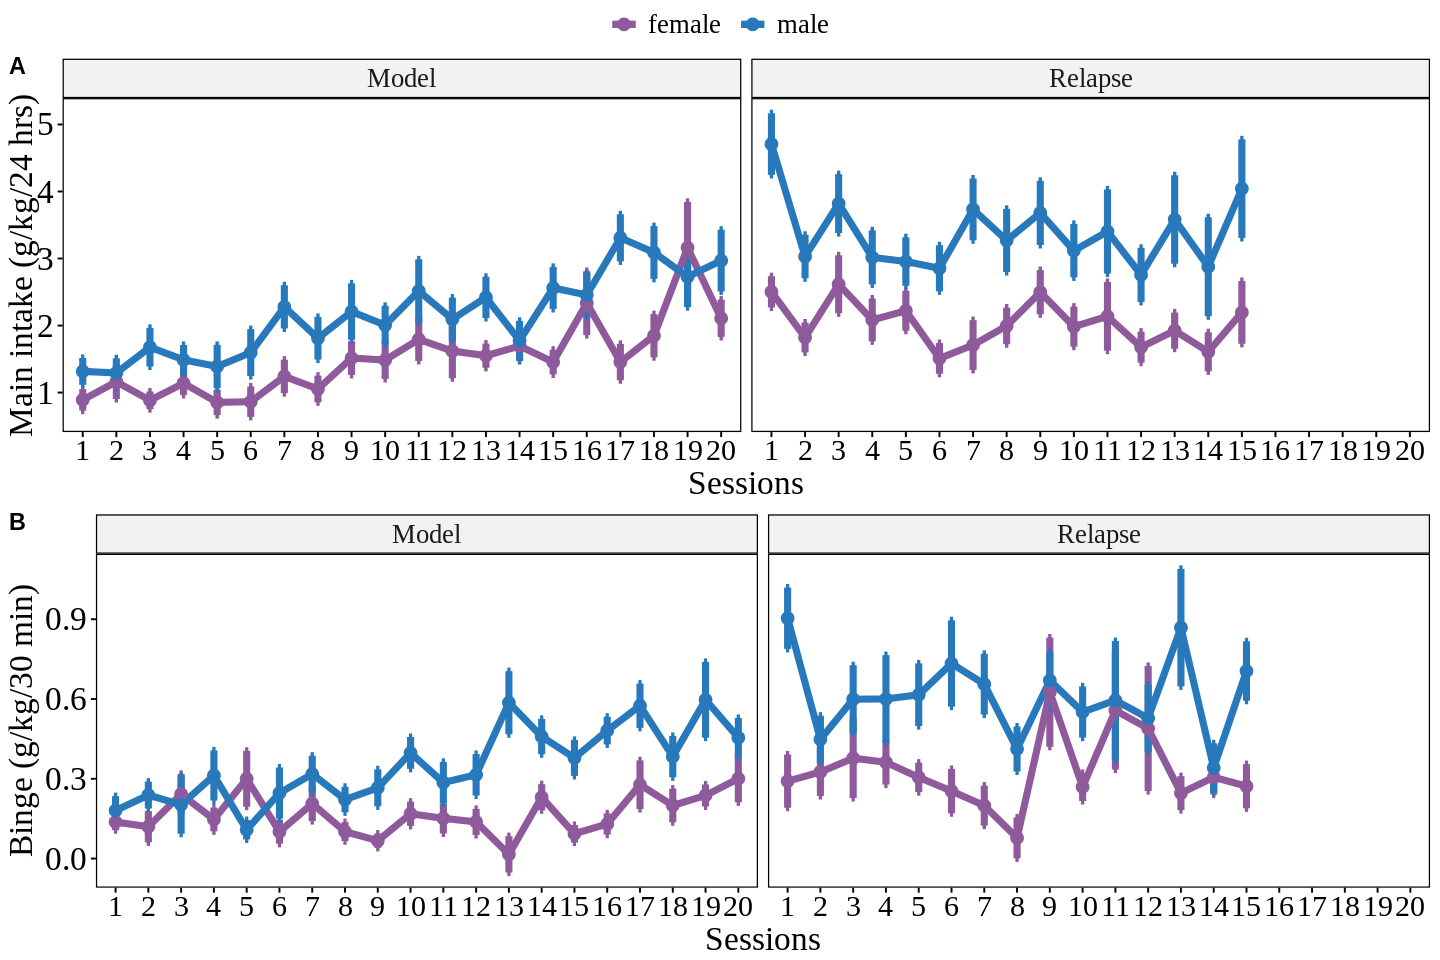

In [34]:
plot_consumption <-  ggarrange(plot_mainIntake, plot_binge, labels = c("A", "B"), ncol = 1, common.legend = T)
plot_consumption

In [46]:
Model_AlcInt_ses_sex <- lmer(formula = main_intake ~ Sex*Session*Phase+Batch+(1|RID), data = Alcohol_intake %>% filter(Group == "Alc"))
emmeans_AlcInt_ses_sex <- emmeans(Model_AlcInt_ses_sex, specs = pairwise ~ Sex|Session|Phase, adjust="fdr", infer = c(T, T))
emmeans_AlcInt_ses_sex$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance() %>% arrange(Session)

fixed-effect model matrix is rank deficient so dropping 10 columns / coefficients



contrast,Session,Phase,estimate,SE,df,lower.CL,upper.CL,t.ratio,p.value,p.value.signif
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
female - male,1,Relapse,-3.235953,0.6549507,418.9184,-4.523352,-1.94855362,-4.940758,1.126902e-06,****
female - male,12,Model,-1.279520,0.6250002,377.0693,-2.508443,-0.05059789,-2.047232,4.132791e-02,*
female - male,12,Relapse,-2.745489,1.1316302,743.0513,-4.967062,-0.52391628,-2.426137,1.549755e-02,*
female - male,13,Relapse,-3.812556,1.1316302,743.0513,-6.034129,-1.59098294,-3.369083,7.930925e-04,***
female - male,14,Relapse,-2.413223,1.1316302,743.0513,-4.634796,-0.19164961,-2.132519,3.329144e-02,*
female - male,15,Model,-1.845777,0.6250002,377.0693,-3.074699,-0.61685430,-2.953242,3.341579e-03,**
female - male,17,Model,-1.784054,0.6250002,377.0693,-3.012976,-0.55513122,-2.854485,4.548776e-03,**
female - male,2,Relapse,-1.276398,0.6436839,403.2994,-2.541793,-0.01100380,-1.982959,4.805003e-02,*
female - male,7,Relapse,-2.498518,0.6549481,418.6924,-3.785914,-1.21112213,-3.814834,1.568010e-04,***


In [45]:
Model_AlcStrInt_ses_sex <- lmer(formula = main_intake ~ Sex*Session*Phase+Batch+(1|RID), data = Alcohol_intake %>% filter(Group == "Alc+Str"))
emmeans_AlcStrInt_ses_sex <- emmeans(Model_AlcStrInt_ses_sex, specs = pairwise ~ Sex|Session|Phase, adjust="fdr", infer = c(T, T))
emmeans_AlcStrInt_ses_sex$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance() %>% arrange(Session)

fixed-effect model matrix is rank deficient so dropping 10 columns / coefficients



contrast,Session,Phase,estimate,SE,df,lower.CL,upper.CL,t.ratio,p.value,p.value.signif
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
female - male,1,Relapse,-1.443358,0.7219404,650.1421,-2.860975,-0.0257421,-1.999276,0.045994198,*
female - male,15,Relapse,-1.897374,0.7093748,636.0072,-3.290374,-0.5043736,-2.674712,0.007671654,**
female - male,17,Model,-1.923945,0.7093748,636.0072,-3.316945,-0.5309451,-2.712170,0.006865168,**
female - male,3,Relapse,-2.697673,1.0213496,827.2420,-4.702415,-0.6929316,-2.641283,0.008415126,**
female - male,6,Relapse,-1.977588,0.7093748,636.0072,-3.370588,-0.5845879,-2.787790,0.005465455,**
female - male,7,Relapse,-1.811802,0.7093748,636.0072,-3.204802,-0.4188022,-2.554083,0.010878748,*
female - male,9,Relapse,-1.532550,0.7218202,650.2143,-2.949930,-0.1151697,-2.123174,0.034116406,*


In [37]:
significant_sessions_alc_sex <- emmeans_AlcInt_ses_sex$contrasts %>% as_tibble %>% 
    filter(p.value < 0.05)  %>% add_significance() %>% mutate(p.value.signif = "*")

# Create the plot
plot_group_alc_sex <- Alcohol_intake %>% filter(Group == "Alc") %>% 
    ggline(x = "Session", y =  "main_intake", group = "Sex", point.size = 3,
        add = c("mean_se"), size=2, color = "Sex", facet.by = "Phase", palette = pal_sex,
        legend.title = "Sex", 
        ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings +
    geom_text(data = significant_sessions_alc_sex, aes(x = Session, y = 7.12, label = p.value.signif), size = 6, vjust = -1)


significant_sessions_alcstr_sex <- emmeans_AlcStrInt_ses_sex$contrasts %>% as_tibble %>% 
    filter(p.value < 0.05)  %>% add_significance() %>% mutate(p.value.signif = "*")

# Create the plot
plot_group_alcstr_sex <- Alcohol_intake %>% filter(Group == "Alc+Str") %>% 
    ggline(x = "Session", y =  "main_intake", group = "Sex", point.size = 3,
        add = c("mean_se"), size=2, color = "Sex", facet.by = "Phase", palette = pal_sex,
        legend.title = "Sex", 
        ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings +
    geom_text(data = significant_sessions_alcstr_sex, aes(x = Session, y = 5.6, label = p.value.signif), size = 6, vjust = -1)

In [ ]:
ggsave(plot = plot_group_alc_sex, dpi=300,height = 8, width = 15,bg="white",
        filename = "Figures/Consumption/Main_intake_Alc-sex.png")

ggsave(plot = plot_group_alcstr_sex, dpi=300,height = 8, width = 15,bg="white",
        filename = "Figures/Consumption/Main_intake_AlcStr-sex.png")

### **5.2 Alcohol intake by consumption pattern**

#### 5.2.1 Main intake along the whole protocol

In [40]:
plot_group <- Alcohol_intake %>% 
    ggline(x = "Session", y =  "main_intake", group = "Group", point.size = 3,
        add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[c(2,4)],
        legend.title = "Group", 
        ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings 

In [41]:
# Filter the emmeans_AlcInt_ses$contrasts dataframe to only include rows where p.value < 0.05
significant_sessions_M <- emmeans_AlcInt_ses$contrasts %>% as_tibble %>% 
    filter(p.value < 0.05)  %>% add_significance() %>% filter(Sex == "male") %>% mutate(p.value.signif = "*")

# Create the plot
plot_group_M <- Alcohol_intake %>% filter(Sex == "male") %>% 
    ggline(x = "Session", y =  "main_intake", group = "Group", point.size = 3,
        add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[c(2,4)],
        legend.title = "Group", 
        ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings +
    geom_text(data = significant_sessions_M, aes(x = Session, y = 7.05, label = p.value.signif), size = 6, vjust = -1)

# Filter the emmeans_AlcInt_ses$contrasts dataframe to only include rows where p.value < 0.05
significant_sessions_F <- emmeans_AlcInt_ses$contrasts %>% as_tibble %>% 
    filter(p.value < 0.05)  %>% add_significance() %>% filter(Sex == "female") %>% mutate(p.value.signif = "*")

# Create the plot
plot_group_F <- Alcohol_intake %>% filter(Sex == "female") %>% 
    ggline(x = "Session", y =  "main_intake", group = "Group", point.size = 3,
        add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[c(2,4)],
        legend.title = "Group", 
        ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings +
    geom_text(data = significant_sessions_F, aes(x = Session, y = 5.2, label = p.value.signif), size = 6, vjust = -1)



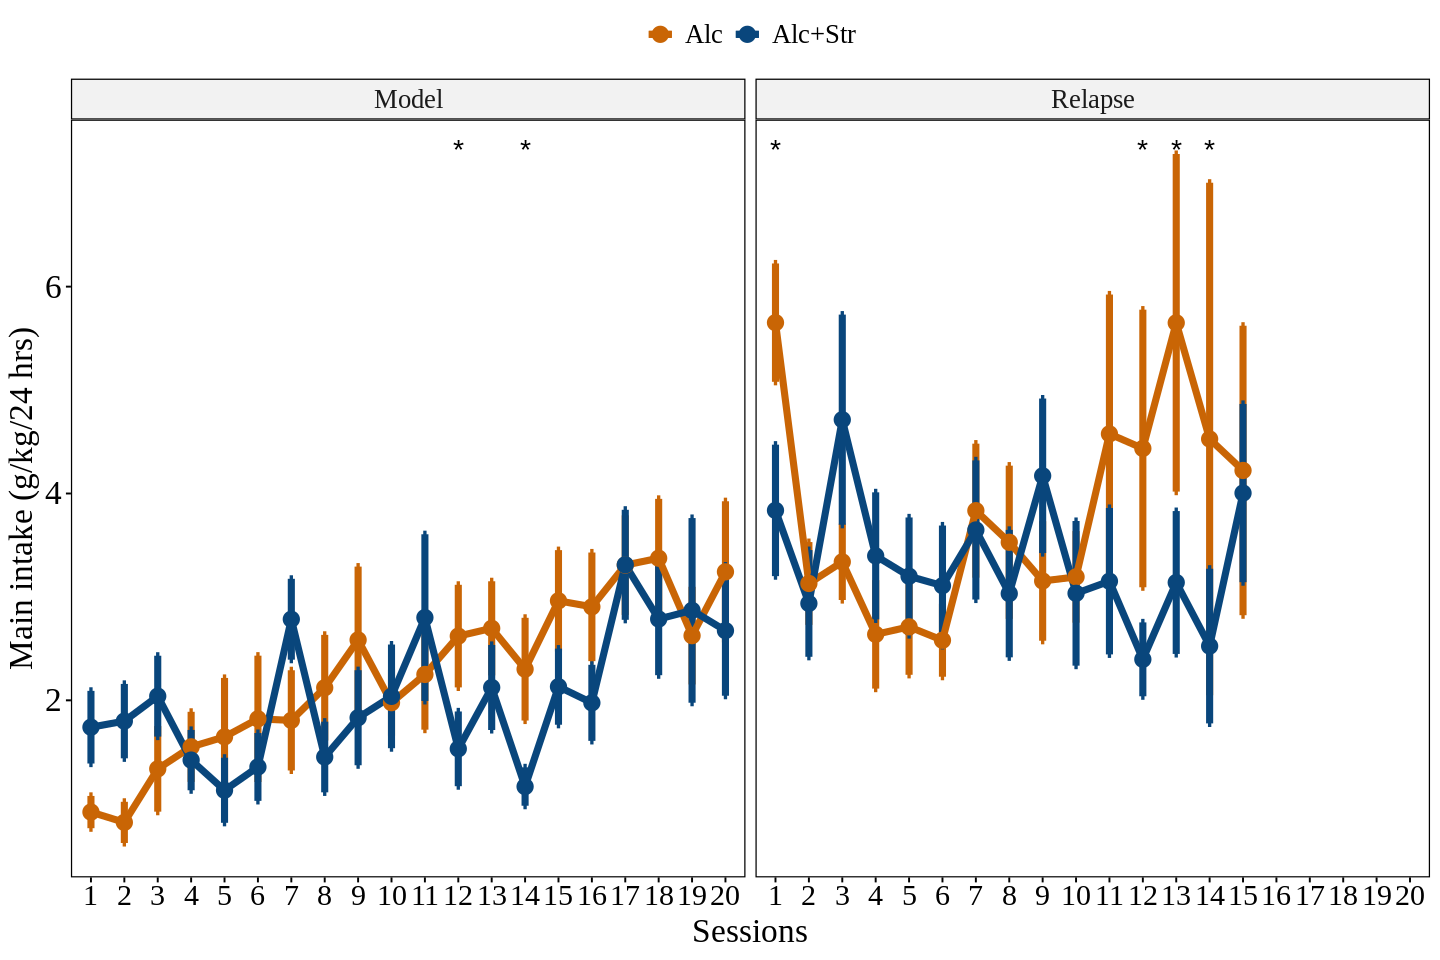

In [44]:
plot_group_M

#### 5.2.2 Binge along the whole protocol

In [42]:
plot_group_binge <- Alcohol_intake %>% 
    ggline(x = "Session", y =  "Binge", group = "Group", point.size = 3,
           add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[c(2,4)],
           legend.title = "Group", 
           ylab = "Binge (g/kg/30 min)", xlab = "Sessions") + theme_settings

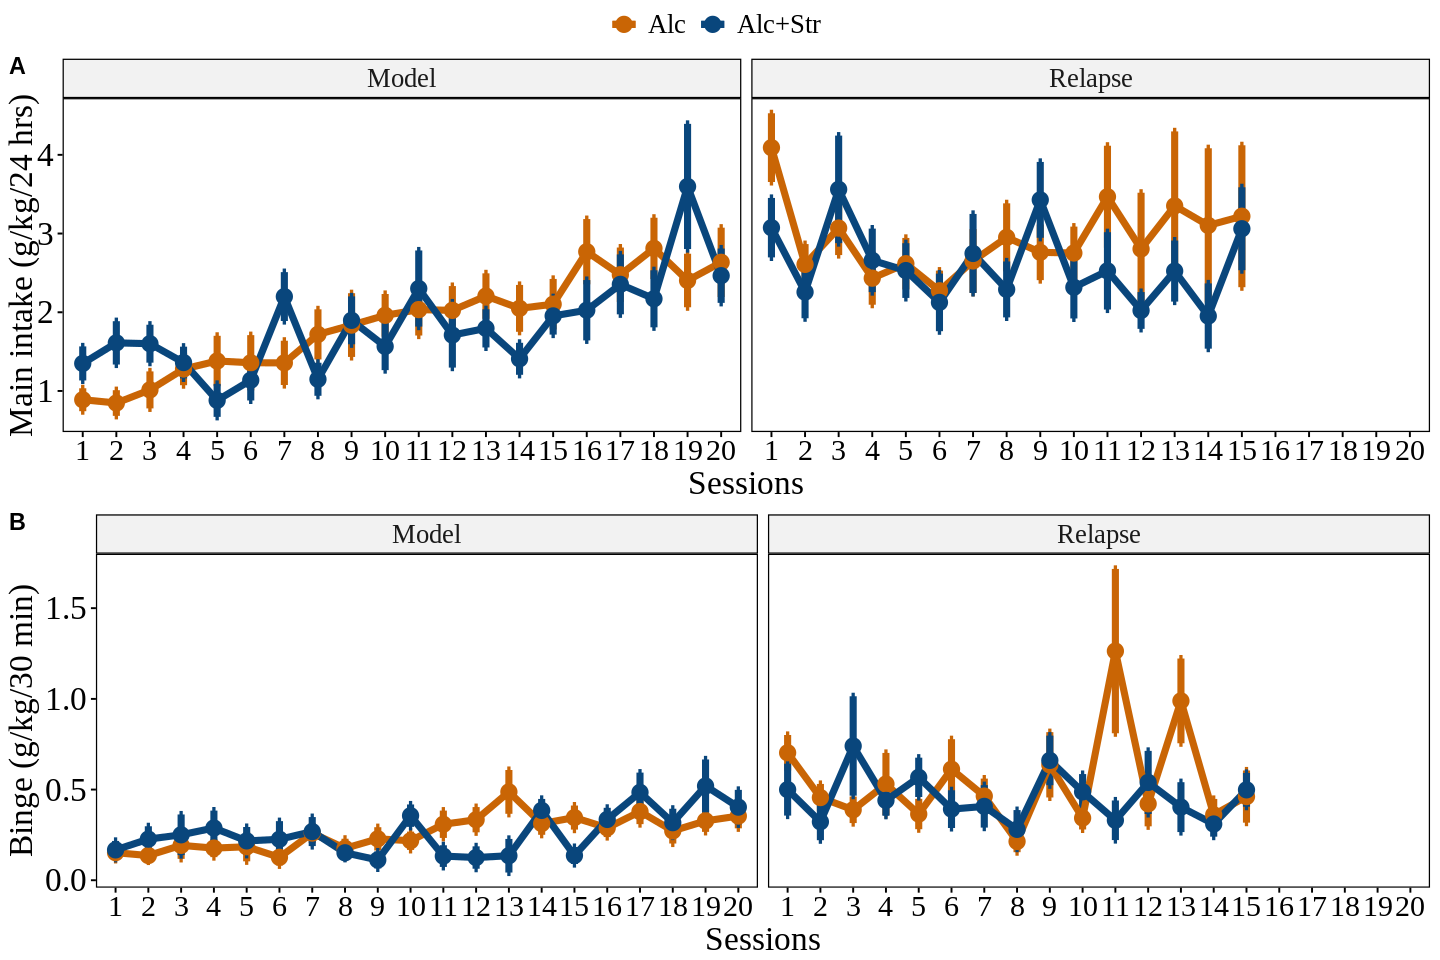

In [43]:
plot_clss_consumption <-  ggarrange(plot_group, plot_group_binge, labels = c("A", "B"), ncol = 1, common.legend = T)
plot_clss_consumption

#### **5.3 Alcohol deprivation effect**

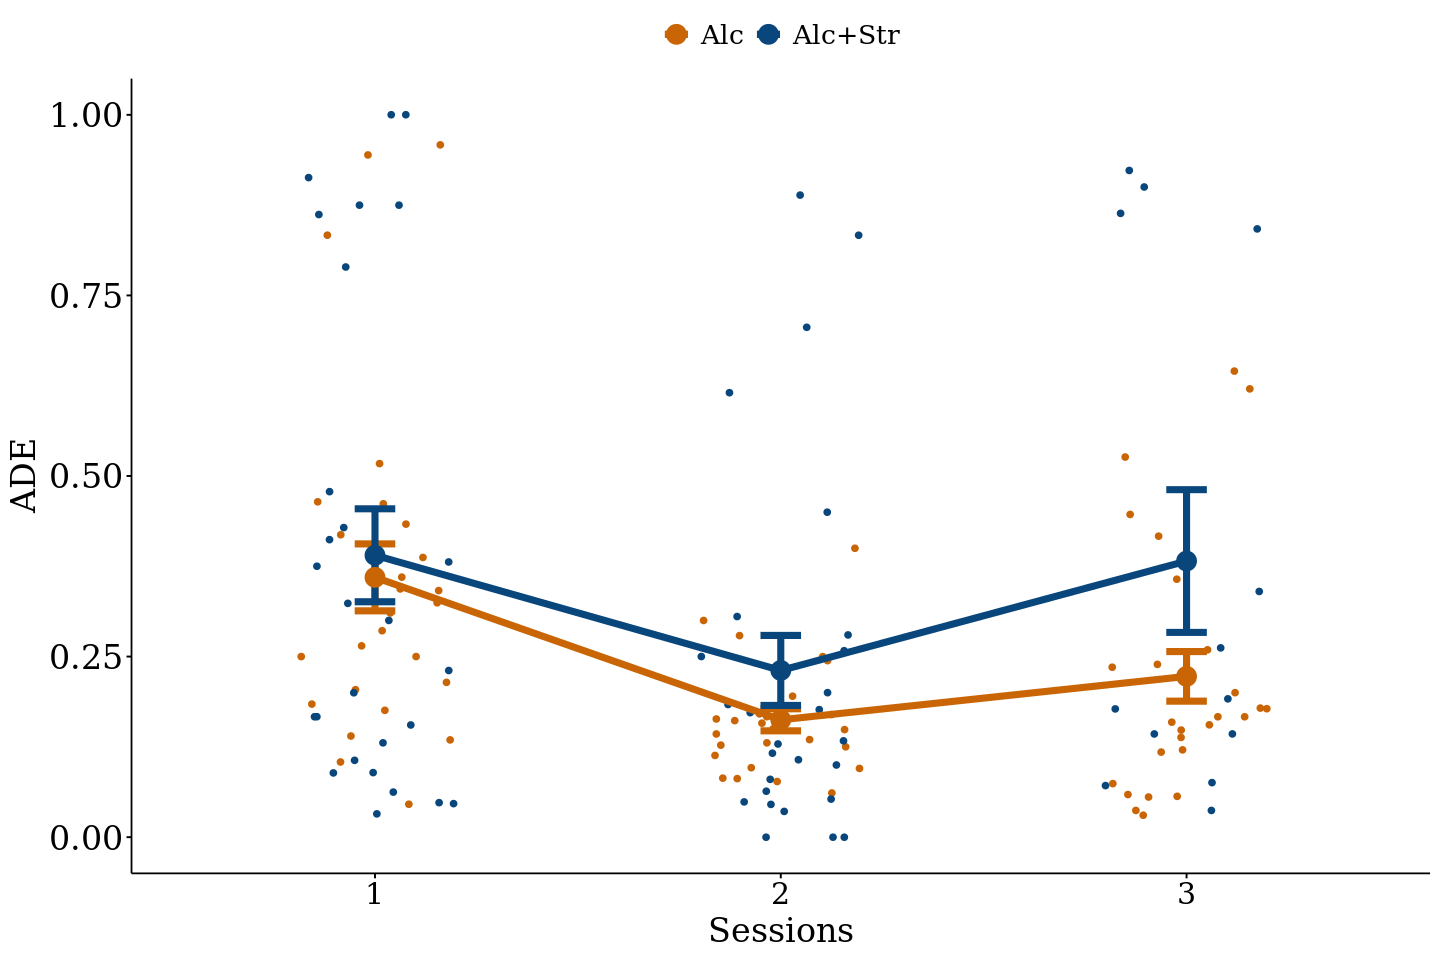

In [ ]:
plot_ADE <- ggline(ADE, x = "Session", y =  "ADE", group = "Group",
                add = c("mean_se", "jitter"), point.size = 4, 
                size=2, color = "Group", palette = pal_group[c(2,4)],
                xlab = "Sessions", ylab = "ADE") + theme_settings
plot_ADE

#### **5.4 Preferency index**

In [ ]:
significant_pref_sessions_M <- emmeans_AlcPref_ses$contrasts %>% as_tibble %>% 
        filter(p.value < 0.05)  %>% add_significance() %>% filter(Sex == "male") %>% mutate(p.value.signif = "*")

plot_preferency_M <- Alcohol_intake %>% filter(Sex == "male") %>% ggline(x = "Session", y =  "Preferency", group = "Group", point.size = 3,
        add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[c(2,4)],
        legend.title = "Group", 
        ylab = "Preferency index", xlab = "Sessions") + theme_settings +
        geom_text(data = significant_pref_sessions_M, aes(x = Session, y = 0.505, label = p.value.signif), size = 6, vjust = -1)

significant_pref_sessions_F <- emmeans_AlcPref_ses$contrasts %>% as_tibble %>% 
        filter(p.value < 0.05)  %>% add_significance() %>% filter(Sex == "female") %>% mutate(p.value.signif = "*")

plot_preferency_F <- Alcohol_intake %>% filter(Sex == "female") %>% ggline(x = "Session", y =  "Preferency", group = "Group", point.size = 3,
        add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group[c(2,4)],
        legend.title = "Group", 
        ylab = "Preferency index", xlab = "Sessions") + theme_settings +
        geom_text(data = significant_pref_sessions_F, aes(x = Session, y = 0.3, label = p.value.signif), size = 6, vjust = -1)


#### **5.4 Corticosterone Concentration**

In [ ]:
B5_cort <- read_xlsx("Data/Cort/corticosterone.xlsx",sheet = 1)
B8_cort <- read_xlsx("Data/Cort/corticosterone.xlsx",sheet = 2)

In [ ]:
model4pl <- function(Concentration, Background, Mid, Slope, Bmax) {
    Bmax + ((Background - Bmax) / (1 + ((Concentration/Mid)^Slope)))
    }

CalcConc <- function(Background, Mid, Slope, Bmax, y) {
  as.numeric(Mid * ((Background - Bmax)/(y - Bmax) - 1)^(1/Slope))
    }

In [ ]:
B5_calibration <- B5_cort %>% filter(Group == "estandar")
B8_calibration <- B8_cort %>% filter(Group == "estandar")

# For batch 5
B5_fit <- nls(Abs ~ model4pl(Concentration, Background, Mid, Slope, Bmax),
            data = B5_calibration,
            start = c(Background=0, Mid=100, Slope=1, Bmax=4),
            control = nls.control(maxiter=1000, warnOnly=TRUE) )
cor(B5_calibration$Abs, predict(B5_fit))

# For batch 8
B8_fit <- nls(Abs ~ model4pl(Concentration, Background, Mid, Slope, Bmax),
            data = B8_calibration,
            start = c(Background=0, Mid=100, Slope=1, Bmax=4),
            control = nls.control(maxiter=1000, warnOnly=TRUE) )
cor(B8_calibration$Abs, predict(B8_fit))

[1] 0.9996098

[1] 0.9993784

In [ ]:
B5_predicted_values <- B5_cort %>% anti_join(B5_calibration) %>% 
    mutate(Concentration = CalcConc(
        coef(B5_fit)["Background"],
        coef(B5_fit)["Mid"],
        coef(B5_fit)["Slope"],
        coef(B5_fit)["Bmax"],
        y = Abs
        ))

B8_predicted_values <- B8_cort %>% anti_join(B8_calibration) %>%
    mutate(Concentration = CalcConc(
        coef(B8_fit)["Background"],
        coef(B8_fit)["Mid"],
        coef(B8_fit)["Slope"],
        coef(B8_fit)["Bmax"],
        y = Abs
        ))

Joining with `by = join_by(RID, Group, Sex, Batch, Abs, Concentration)`


Joining with `by = join_by(RID, Group, Sex, Batch, Abs, Concentration)`


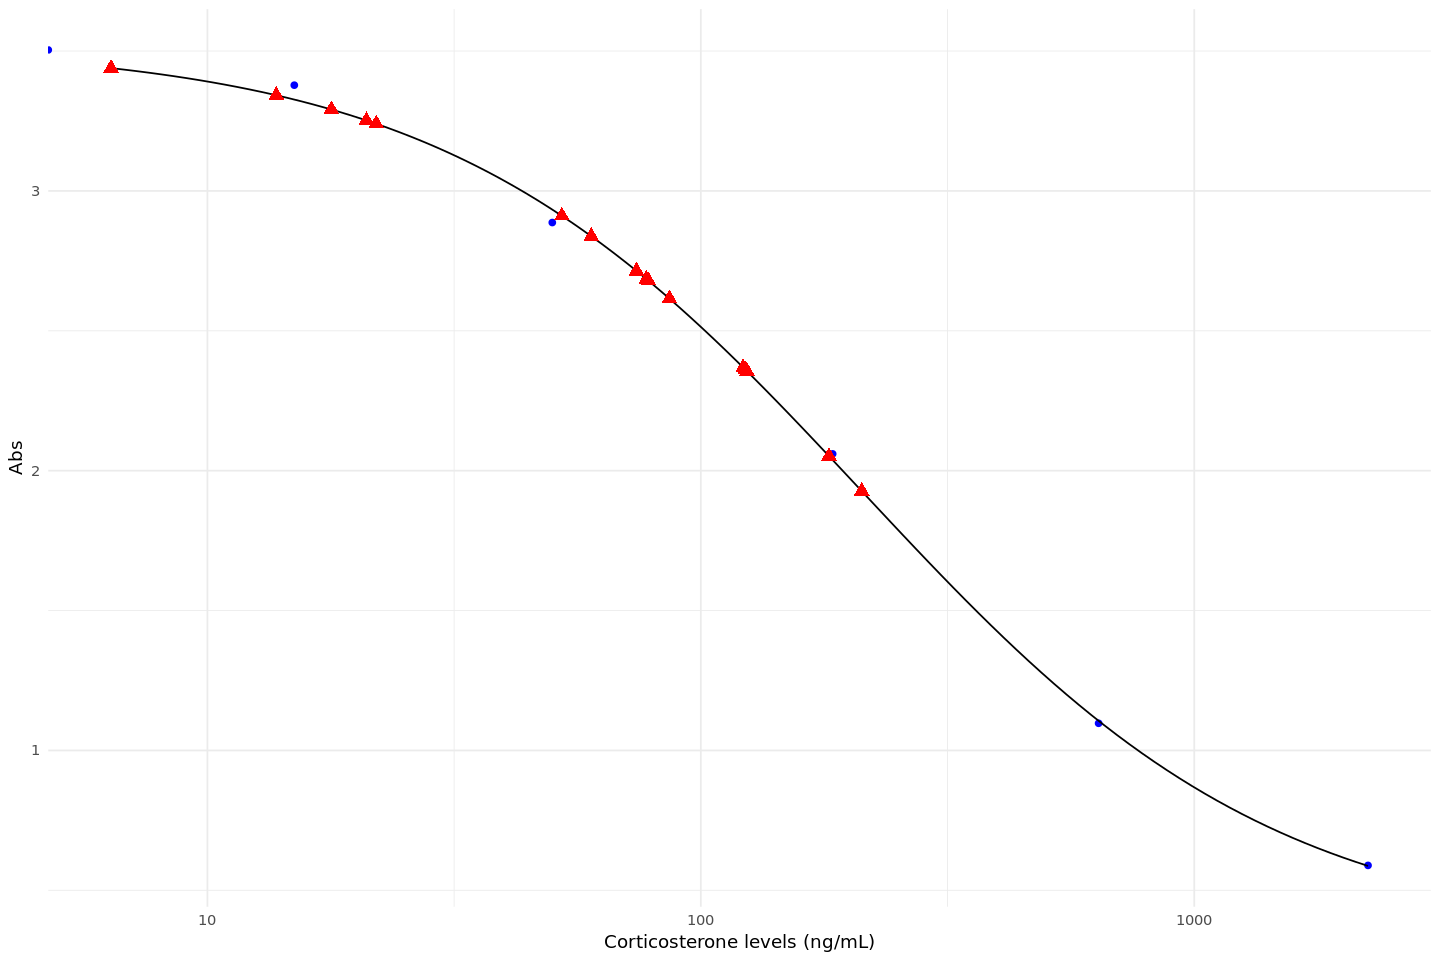

In [ ]:
ggplot(data = B5_calibration) +
    geom_point(aes(Concentration, Abs), color = "blue")+
    scale_x_log10() +
    stat_function(data = B5_calibration, fun  = model4pl,
                    args = list(Mid = coef(B5_fit)["Mid"],
                                Background = coef(B5_fit)["Background"],
                                Slope = coef(B5_fit)["Slope"],
                                Bmax = coef(B5_fit)["Bmax"])) +
    geom_point(data = B5_predicted_values, aes(x = Concentration, y = Abs), 
                shape = 17, size = 3, color = "red") +
    labs(x = "Corticosterone levels (ng/mL)", y = "Abs") +  # Etiquetas de ejes
    theme_minimal()

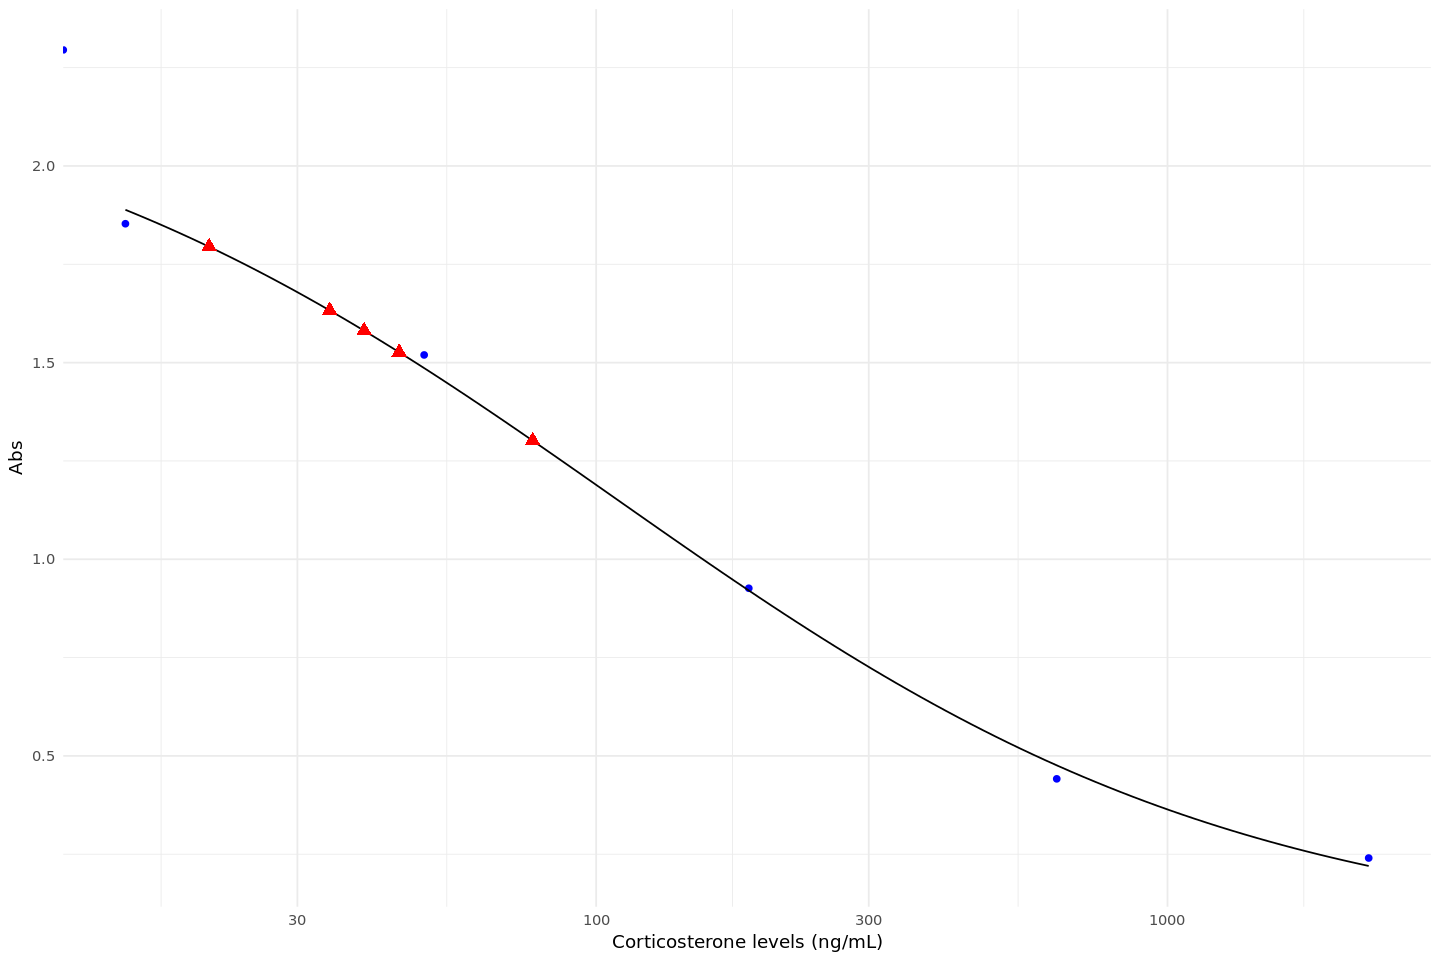

In [ ]:
ggplot(data = B8_calibration) +
    geom_point(aes(Concentration, Abs), color = "blue")+
    scale_x_log10() +
    stat_function(data = B8_calibration, fun  = model4pl,
                    args = list(Mid = coef(B8_fit)["Mid"],
                                Background = coef(B8_fit)["Background"],
                                Slope = coef(B8_fit)["Slope"],
                                Bmax = coef(B8_fit)["Bmax"])) +
    geom_point(data = B8_predicted_values, aes(x = Concentration, y = Abs), 
                shape = 17, size = 3, color = "red") +
    labs(x = "Corticosterone levels (ng/mL)", y = "Abs") +  # Etiquetas de ejes
    theme_minimal()

In [ ]:
Corticosterone_values <- B5_predicted_values %>% rbind(B8_predicted_values) %>% 
    mutate(Concentration = Concentration *2.886) %>% 
    mutate(Group = case_when(Group == "Ctrl" ~ "EtOH-/CRS-", Group == "Alc" ~ "EtOH+/CRS-", 
                            Group == "Str" ~ "EtOH-/CRS+",Group == "Alc+Str" ~ "EtOH+/CRS+"),
                            Group = factor(Group, levels = c("EtOH-/CRS-", "EtOH+/CRS-", "EtOH-/CRS+", "EtOH+/CRS+")))

In [ ]:
Model_cort <- lm(formula = Concentration ~ Group+Sex+Batch, data = Corticosterone_values)

In [ ]:
emmeans_cort <- emmeans(Model_cort, specs = pairwise ~ Group, adjust="fdr")
emmeans_cort$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

contrast,estimate,SE,df,t.ratio,p.value,p.value.signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(EtOH-/CRS-) - (EtOH-/CRS+),-255.6856,73.66521,15,-3.470915,0.006843568,**
(EtOH-/CRS-) - (EtOH+/CRS+),-307.6211,73.66521,15,-4.175934,0.004868517,**
(EtOH+/CRS-) - (EtOH-/CRS+),-224.0581,74.43257,15,-3.010215,0.013181991,*
(EtOH+/CRS-) - (EtOH+/CRS+),-275.9935,74.93979,15,-3.682870,0.006646442,**


In [ ]:
contrast_cort <- emmeans_cort$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance() %>% 
    separate(contrast, into = c("group1", "group2"), sep = " - ", remove = FALSE) %>%
    mutate(group1 = gsub("\\(|\\)", "", group1),
            group2 = gsub("\\(|\\)", "", group2))

##### Plotting

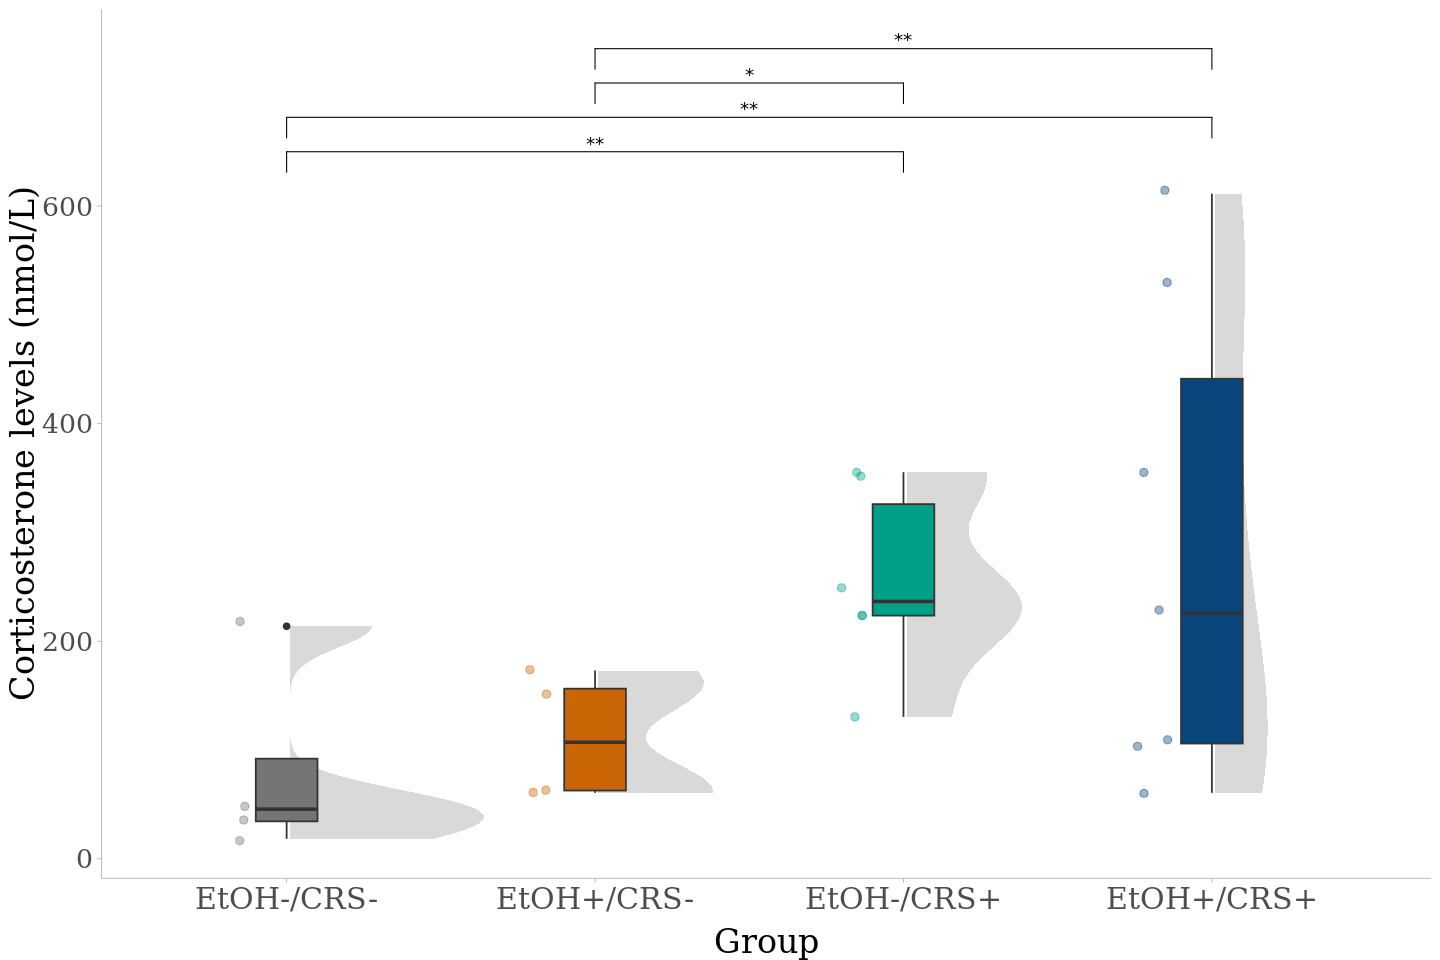

In [ ]:
plot_corticosterone <- Corticosterone_values %>% ggplot(aes(x = Group,y = Concentration, 
                fill = Group)) + 
    stat_halfeye(
        adjust = .8, width = .7, fill = "grey85",
        interval_colour = NA, 
        position = position_nudge(x = .01),
        aes(thickness = stat(f*n))) +
    gghalves::geom_half_point(aes(color = Group),
                                side = "l", 
                                range_scale = .3, 
                                alpha = .4, size = 2) +
    geom_boxplot(width = .2) + 
    ylab("Corticosterone levels (nmol/L)") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
    theme_ggdist() +
    theme(text = element_text(size = 18), legend.position = "none",
            plot.subtitle = element_text(hjust = 1)) + 
    theme_settings +
    stat_pvalue_manual(contrast_cort, label = "p.value.signif",y.position = 650, step.increase = 0.05, inherit.aes = F)
plot_corticosterone

### **5.5 Weight**

In [ ]:
Wsignificant_sessions_M <- emmeans_weight_ses$contrasts %>% as_tibble %>% 
    filter(p.value < 0.05)  %>% add_significance() %>% filter(Sex == "male") %>% mutate(p.value.signif = "*")

plot_weight_male <- Weight_intake %>% filter(Sex == "male") %>%
    ggline(x = "Session", y =  "Weight_change", group = "Group", point.size = 3,
            add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group,
            legend.title = "Group", 
            ylab = "Δ Weight (gr)", xlab = "Sessions") + theme_settings +
    geom_text(data = significant_sessions_M, aes(x = Session, y = 0.32, label = p.value.signif), size = 6, vjust = -1)

Wsignificant_sessions_F <- emmeans_weight_ses$contrasts %>% as_tibble %>% 
    filter(p.value < 0.05)  %>% add_significance() %>% filter(Sex == "female") %>% mutate(p.value.signif = "*")

plot_weight_female <- Weight_intake %>% filter(Sex == "female") %>%
    ggline(x = "Session", y =  "Weight_change", group = "Group", point.size = 3,
            add = c("mean_se"), size=2, color = "Group", facet.by = "Phase", palette = pal_group,
            legend.title = "Group", 
            ylab = "Δ Weight (gr)", xlab = "Sessions") + theme_settings +
    geom_text(data = significant_sessions_M, aes(x = Session, y = 0.16, label = p.value.signif), size = 6, vjust = -1)

## **6. Export data**

In [ ]:
ggsave(plot = plot_group_M, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/Consumption/Main_intake-male.png")

ggsave(plot = plot_group_F, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/Consumption/Main_intake-female.png")

In [ ]:
dir.create("Figures/Weight",recursive = T)

In [ ]:
ggsave(plot = plot_weight_male, dpi=300,height = 8, width = 12,bg="white",
        filename = "Figures/Weight/Weight-male.png")

ggsave(plot = plot_weight_male, dpi=300,height = 8, width = 12,bg="white",
        filename = "Figures/Weight/Weight-female.png")

In [ ]:
ggsave(plot = plot_corticosterone, dpi=300,height = 8, width = 10,bg="white",
        filename = "Figures/Corticosterone/corticosterone_levels.png")

In [ ]:
save(list = ls(), file = paste0(getwd(),"/Data/Alcohol_consumption.RData"))
